In [1]:
import os, pandas as pd, numpy as np
from joblib import dump, load
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from sod.evaluation.datasets import oneminutewindows

dataframe = oneminutewindows(os.path.join(os.getcwd(), '..', '..', 'tmp', 'datasets', 'oneminutewindows.hdf'), normalize_=True)

predictions = pd.read_hdf(os.path.join(os.getcwd(), '..', '..', 'tmp', 'evaluation-results', 'oneminutewindows.ocsvm.yaml',
                                      'OneClassSVM?features=psd@2sec,psd@5sec&gamma=50&kernel=rbf&nu=0.1&cache_size=1500.evalpredictions.hdf'))

print('predictions: %d' % len(predictions))
predictions['modified'] = predictions['modified'].astype('category')


clf50 = load(os.path.join(os.getcwd(), '..', '..', 'tmp', 'evaluation-results', 'oneminutewindows.ocsvm.yaml',
                       'OneClassSVM?features=psd@2sec,psd@5sec&gamma=50&kernel=rbf&nu=0.1&cache_size=1500.model'))

Opening /Users/riccardo/work/gfz/projects/sources/python/sod/tmp/datasets/oneminutewindows.hdf

                                instances
ok                              1,003,203
outl. (wrong inv. file)             4,356
outl. (cha. resp. acc <-> vel)  1,181,439
outl. (gain X100 or X0.01)      1,003,203
outl. (gain X10 or X0.1)        1,003,203
outl. (gain X2 or X0.5)         1,003,203
total                           5,198,607

Normalizing numeric columns (floats only)
(only good instances - no outliers - taken into account)
                  min median   max      NAs ids outside[1-99]%
psd@0.05sec      0.00   0.97  1.13    2,652             10,647
psd@0.1sec       0.00   0.97  1.12        0             10,890
psd@0.2sec       0.00   0.97  1.10        4             10,938
psd@0.5sec       0.00   0.97  1.10       16             11,261
psd@1sec         0.00   0.97  1.10       40             11,464
psd@2sec         0.00   0.97  1.09      106             10,982
psd@3sec         0.00   0.9

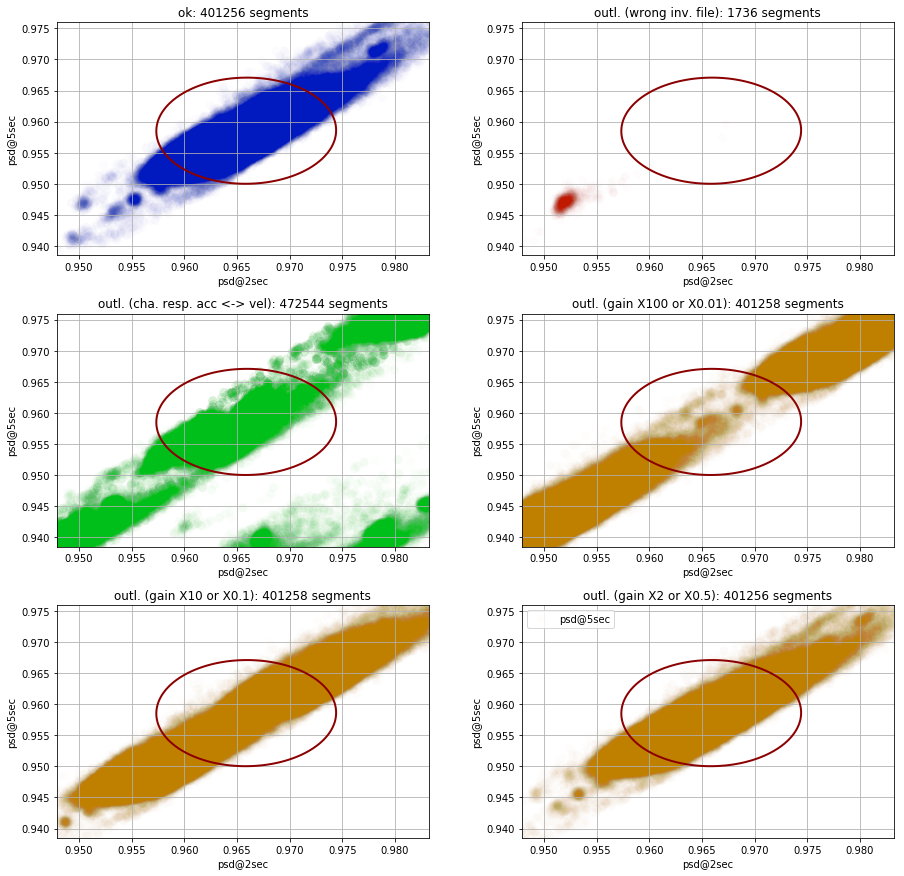

In [15]:
import importlib
import sod.plot as sod_plot
importlib.reload(sod_plot)

%matplotlib inline

fig = sod_plot.plot(dataframe, 'psd@2sec', 'psd@5sec', axis_lim=0.945, clfs={'bah': clf50}) 

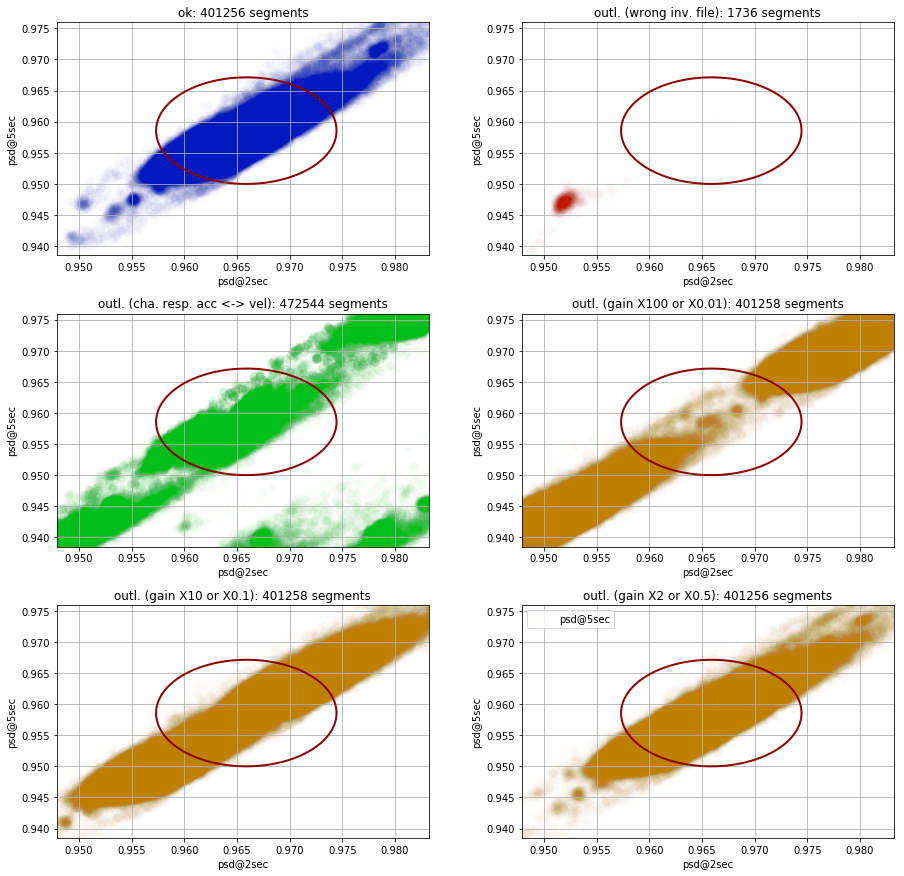

In [17]:
clf10 = load(os.path.join(os.getcwd(), '..', '..', 'tmp', 'evaluation-results', 'oneminutewindows.ocsvm.yaml',
                       'OneClassSVM?features=psd@2sec,psd@5sec&gamma=10&kernel=rbf&nu=0.1&cache_size=1500.model'))

fig = sod_plot.plot(dataframe, 'psd@2sec', 'psd@5sec', axis_lim=0.945, clfs={'bah': clf10}) 

In [18]:
print(str(clf))

OneClassSVM(cache_size=1500, coef0=0.0, degree=3, gamma=50, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)


In [19]:
print(str(clf10))

OneClassSVM(cache_size=1500, coef0=0.0, degree=3, gamma=10, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)
